# Running HMETS on the 5797 basins of the extended CANOPEX dataset

Here we use birdy's WPS client to launch the HMETS hydrological model on the server and analyze the output. We also prepare and gather data directly from the CANOPEX dataset made available freely for all users.

In [1]:
# Cookie-cutter template necessary to provide the tools, packages and paths for the project. All notebooks
# need this template (or a slightly adjusted one depending on the required packages)
import datetime as dt
import glob
import json
import os
import tempfile
from pathlib import Path
from urllib.request import urlretrieve
from zipfile import ZipFile

import netCDF4 as nc
import numpy as np
import pandas as pd
import spotpy
import xarray as xr
from matplotlib import pyplot as plt

from ravenpy.new_config import commands as rc
from ravenpy.new_config.emulators import HMETS
from ravenpy.utilities.new_config.calibration import SpotSetup
from ravenpy.utilities.testdata import get_file

# DATA MAIN SOURCE - DAP link to CANOPEX dataset. Can be DAP or direct URL:
CANOPEX_DAP = "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/ets/Watersheds_5797_cfcompliant.nc"
CANOPEX_URL = "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/fileServer/birdhouse/ets/Watersheds_5797_cfcompliant.nc"

# Prefer the DAP link
ds = xr.open_dataset(CANOPEX_DAP)

In [2]:
# Explore the dataset:
display(ds)

<xarray.Dataset>
Dimensions:        (time: 22280, watershed: 5797)
Coordinates:
  * time           (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2010-12-31
  * watershed      (watershed) |S64 b'St. John River at Ninemile Bridge, Main...
Data variables:
    drainage_area  (watershed) float64 ...
    pr             (watershed, time) float64 ...
    tasmax         (watershed, time) float64 ...
    tasmin         (watershed, time) float64 ...
    discharge      (watershed, time) float64 ...
Attributes: (12/15)
    title:          Hydrometeorological data for lumped hydrological modellin...
    institute_id:   ETS
    contact:        Richard Arsenault: richard.arsenault@etsmtl.ca
    date_created:   2020-08-01
    source:         Hydrometric data from USGS National Water Information Ser...
    featureType:    timeSeries
    ...             ...
    activity:       PAVICS_Hydro
    Conventions:    CF-1.6, ACDD-1.3
    summary:        Hydrometeorological database for the PAVICS-Hydro platfor...
    institution:    ETS (École de technologie supérieure)
    DODS.strlen:    72
    DODS.dimName:   string72

In [3]:
# We could explore the dataset and find a watershed of interest, but for now, let's pick one at random
# from the dataset:
watershedID = 5600

# And show what it includes:
ds = ds.isel({"watershed": watershedID})

In [4]:
ds

<xarray.Dataset>
Dimensions:        (time: 22280)
Coordinates:
  * time           (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2010-12-31
    watershed      |S64 b'WHITEMOUTH RIVER NEAR WHITEMOUTH'
Data variables:
    drainage_area  float64 3.75e+03
    pr             (time) float64 ...
    tasmax         (time) float64 ...
    tasmin         (time) float64 ...
    discharge      (time) float64 ...
Attributes: (12/15)
    title:          Hydrometeorological data for lumped hydrological modellin...
    institute_id:   ETS
    contact:        Richard Arsenault: richard.arsenault@etsmtl.ca
    date_created:   2020-08-01
    source:         Hydrometric data from USGS National Water Information Ser...
    featureType:    timeSeries
    ...             ...
    activity:       PAVICS_Hydro
    Conventions:    CF-1.6, ACDD-1.3
    summary:        Hydrometeorological database for the PAVICS-Hydro platfor...
    institution:    ETS (École de technologie supérieure)
    DODS.strlen:    72
    DODS.dimName:   string72

In [5]:
# Let's write the file to disk to make it more efficient to retrieve:
fname = "/tmp/CANOPEX_extracted.nc"
ds.to_netcdf(fname)

In [6]:
# With this info, we can gather some properties from the CANOPEX database. This same database is used for
# regionalization, so let's query it there where more information is available:
tmp = pd.read_csv(get_file("regionalisation_data/gauged_catchment_properties.csv"))

basin_area = float(tmp["area"][watershedID])
basin_latitude = float(tmp["latitude"][watershedID])
basin_longitude = float(tmp["longitude"][watershedID])
basin_elevation = float(tmp["elevation"][watershedID])
basin_name = ds.watershed.data

print("Basin name: ", basin_name)
print("Latitude: ", basin_latitude, " °N")
print("Area: ", basin_area, " km^2")

Basin name:  b'WHITEMOUTH RIVER NEAR WHITEMOUTH'
Latitude:  49.51119663557124  °N
Area:  3650.476384548832  km^2


Now, we might have the model and data, but we don't have model parameters! We need to calibrate. This next snippet shows how to do so.

In [7]:
# We will also calibrate on only a subset of the years for now to keep the computations faster in this notebook.
start_calib = dt.datetime(1998, 1, 1)
end_calib = dt.datetime(1999, 12, 31)

# General parameters depending on the data source. We can find them by exploring the CANOPEX dataset in the
# cells above.
data_type = ["TEMP_MAX", "TEMP_MIN", "PRECIP"]

alt_names = {
    "TEMP_MIN": "tasmin",
    "TEMP_MAX": "tasmax",
    "PRECIP": "pr",
}

hru = {}
hru = dict(
    area=basin_area,
    elevation=basin_elevation,
    latitude=basin_latitude,
    longitude=basin_longitude,
    hru_type="land",
)

data_kwds = {
    "ALL": {
        "elevation": hru["elevation"],
        "latitude": hru["latitude"],
        "longitude": hru["longitude"],
    }
}
# Set the evaluation metrics to be calculated by Raven
eval_metrics = ("NASH_SUTCLIFFE",)

model_config = HMETS(
    ObservationData=[
        rc.ObservationData.from_nc(fname, alt_names="discharge", station_idx=1)
    ],
    Gauge=[
        rc.Gauge.from_nc(
            fname,
            station_idx=1,
            data_type=data_type,  # Note that this is the list of all the variables
            alt_names=alt_names,  # Note that all variables here are mapped to their names in the netcdf file.
            data_kwds=data_kwds,
        )
    ],
    HRUs=[hru],
    StartDate=start_calib,
    EndDate=end_calib,
    RunName="CANOPEX_test",
    EvaluationMetrics=eval_metrics,
    RainSnowFraction="RAINSNOW_DINGMAN",
    SuppressOutput=True,
)

Now that the model is setup, we can focus on calibrating the parameters using SpotPy:

In [8]:
%%capture --no-display

# The model parameters bounds can either be set independently or we can use the defaults.
low_params = (
    0.3,
    0.01,
    0.5,
    0.15,
    0.0,
    0.0,
    -2.0,
    0.01,
    0.0,
    0.01,
    0.005,
    -5.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.00001,
    0.0,
    0.00001,
    0.0,
    0.0,
)
high_params = (
    20.0,
    5.0,
    13.0,
    1.5,
    20.0,
    20.0,
    3.0,
    0.2,
    0.1,
    0.3,
    0.1,
    2.0,
    5.0,
    1.0,
    3.0,
    1.0,
    0.02,
    0.1,
    0.01,
    0.5,
    2.0,
)

# Setup the spotpy optimizer
spot_setup = SpotSetup(
    config=model_config,
    low=low_params,
    high=high_params,
)

Finally, we can run the optimizer:

In [9]:
# We'll definitely want to adjust the random seed and number of model evaluations:
model_evaluations = (
    50  # This is to keep computing time fast for the demo, increase as necessary
)

# Setup the spotpy sampler with the method, the setup configuration, a run name and other options. Please refer to
# the spotpy documentation for more options. We recommend sticking to this format for efficiency of most applications.
sampler = spotpy.algorithms.dds(
    spot_setup,
    dbname="CANOPEX_test",
    dbformat="ram",
    save_sim=False,
)

# Launch the actual optimization. Multiple trials can be launched, where the entire process is repeated and
# the best overall value from all trials is returned.
sampler.sample(model_evaluations, trials=1)

Initializing the  Dynamically Dimensioned Search (DDS) algorithm  with  50  repetitions
The objective function will be maximized
Starting the DDS algotrithm with 50 repetitions...
Finding best starting point for trial 1 using 5 random samples.
Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']


/home/david/src/RavenPy/ravenpy/ravenpy.py:289: RavenWarning: The required global parameter RAINSNOW_TEMP was autogenerated with value 0.150000
  warn(msg, category=RavenWarning)
/home/david/src/RavenPy/ravenpy/ravenpy.py:289: RavenWarning: Because no processes with CANOPY_SNOW variable have been specified, all snow interception will be directly moved to the atmosphere as if it had sublimated.
  warn(msg, category=RavenWarning)
/home/david/src/RavenPy/ravenpy/ravenpy.py:289: RavenWarning: Because no processes with CANOPY variable have been specified, all rain interception will be directly moved to the atmosphere as if it had evaporated.
  warn(msg, category=RavenWarning)


49 of 50, maximal objective function=-20.4123, time remaining: 00:00:00
Best solution found has obj function value of -20.4123 at 5



*** Final SPOTPY summary ***
Total Duration: 2.06 seconds
Total Repetitions: 50
Maximal objective value: -20.4123
Corresponding parameter setting:
GAMMA_SHAPE: 14.1935
GAMMA_SCALE: 4.60781
GAMMA_SHAPE2: 6.63415
GAMMA_SCALE2: 0.422409
MIN_MELT_FACTOR: 0.00212
MAX_MELT_FACTOR: 4.89198
DD_MELT_TEMP: -0.382403
DD_AGGRADATION: 0.0129325
SNOW_SWI_MIN: 0.000315587
SNOW_SWI_MAX: 0.01
SWI_REDUCT_COEFF: 0.0231296
DD_REFREEZE_TEMP: -1.43241
REFREEZE_FACTOR: 0.22332
REFREEZE_EXP: 0.839758
PET_CORRECTION: 1.64145
HMETS_RUNOFF_COEFF: 0.32947
PERC_COEFF: 0.0149954
BASEFLOW_COEFF_1: 0.000144
BASEFLOW_COEFF_2: 0.000791884
TOPSOIL: 0.5
PHREATIC: 1.0047
******************************



[{'sbest': spotpy.parameter.ParameterSet(),
  'trial_initial': [17.490642665057432,
   4.511344620191885,
   4.566367510505006,
   1.4975952092255262,
   3.345229326296153,
   16.07831890699711,
   -0.3887860386212021,
   0.04545759789957373,
   0.005878556683346248,
   0.03387909014047173,
   0.033685796401310336,
   -0.3085292961282615,
   2.4737707395716875,
   0.8368335626898503,
   1.9133068469038292,
   0.36286800397763014,
   0.01532696087289166,
   0.07239929000658352,
   0.003741531223279997,
   0.2874959638119751,
   1.3666824423752262],
  'objfunc_val': -20.4123}]

In [15]:
# Get the model diagnostics
diag = spot_setup.diagnostics

# Print the NSE and the parameter set in 2 different ways:
print("Nash-Sutcliffe value is: " + str(diag["DIAG_NASH_SUTCLIFFE"]))

# Get all the values of each iteration
results = sampler.getdata()

# Get the raw resutlts directly in an array
params = spotpy.analyser.get_best_parameterset(results)[0]
params

Nash-Sutcliffe value is: [-20.5372]
Best parameter set:
GAMMA_SHAPE=14.193476571937737, GAMMA_SCALE=4.607812383503135, GAMMA_SHAPE2=6.634149701901467, GAMMA_SCALE2=0.422409498475848, MIN_MELT_FACTOR=0.00212, MAX_MELT_FACTOR=4.89198278680656, DD_MELT_TEMP=-0.3824032397969396, DD_AGGRADATION=0.012932542355537837, SNOW_SWI_MIN=0.0003155874794640982, SNOW_SWI_MAX=0.01, SWI_REDUCT_COEFF=0.023129568340153766, DD_REFREEZE_TEMP=-1.4324103721477806, REFREEZE_FACTOR=0.22331969010386965, REFREEZE_EXP=0.8397577308991944, PET_CORRECTION=1.6414537822805415, HMETS_RUNOFF_COEFF=0.3294696045433809, PERC_COEFF=0.014995402594324685, BASEFLOW_COEFF_1=0.000144, BASEFLOW_COEFF_2=0.0007918839799879911, TOPSOIL=0.5, PHREATIC=1.0046993158994175


(14.19347657, 4.60781238, 6.6341497, 0.4224095, 0.00212, 4.89198279, -0.38240324, 0.01293254, 0.00031559, 0.01, 0.02312957, -1.43241037, 0.22331969, 0.83975773, 1.64145378, 0.3294696, 0.0149954, 0.000144, 0.00079188, 0.5, 1.00469932)

At this stage, we have calibrated the model on the observations for the desired dates. Now, let's run the model on a longer time period and look at the hydrograph

In [19]:
from ravenpy import Emulator

conf = model_config.set_params(params)
conf.suppress_output = False
out = Emulator(conf).run()

The `hydrograph` and `storage` outputs are netCDF files storing the time series. These files are opened by default using `xarray`, which provides convenient and powerful time series analysis and plotting tools.

In [20]:
out.hydrograph.q_sim

<xarray.DataArray 'q_sim' (time: 730, nbasins: 1)>
array([[0.      ],
       [0.009227],
       [0.018497],
       ...,
       [0.032195],
       [0.032169],
       [0.032144]])
Coordinates:
  * time        (time) datetime64[ns] 1998-01-01 1998-01-02 ... 1999-12-31
    basin_name  (nbasins) object ...
Dimensions without coordinates: nbasins
Attributes:
    units:      m**3 s**-1
    long_name:  Simulated outflows

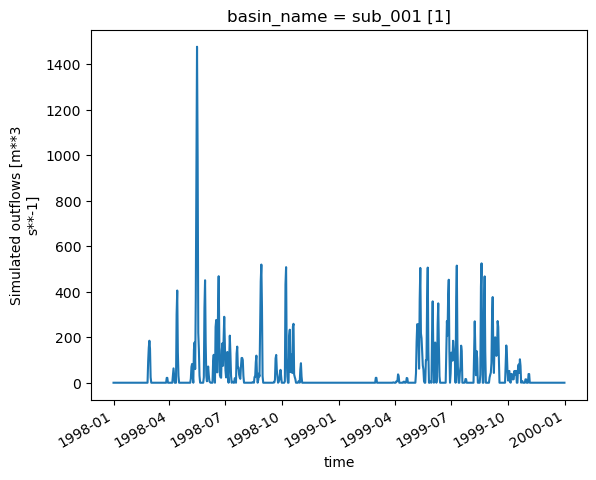

In [22]:
# Plot the simulated hydrograph
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
out.hydrograph.q_sim.plot()

In [24]:
# You can also get statistics from the data directly here.
print("Max: ", out.hydrograph.q_sim.max())
print("Mean: ", out.hydrograph.q_sim.mean())
print(
    "Monthly means: ",
    out.hydrograph.q_sim.groupby(out.hydrograph.time.dt.month).mean(dim="time"),
)

Max:  <xarray.DataArray 'q_sim' ()>
array(1477.30120889)
Mean:  <xarray.DataArray 'q_sim' ()>
array(46.60091093)
Monthly means:  <xarray.DataArray 'q_sim' (month: 12, nbasins: 1)>
array([[2.51135065e-02],
       [7.74897861e+00],
       [4.23834031e+00],
       [1.89053681e+01],
       [1.57622740e+02],
       [1.07794274e+02],
       [6.82993275e+01],
       [7.76269921e+01],
       [5.59890533e+01],
       [5.53412219e+01],
       [1.76424092e+00],
       [3.24910404e-02]])
Coordinates:
    basin_name  (nbasins) object ...
  * month       (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nbasins
Attributes:
    units:      m**3 s**-1
    long_name:  Simulated outflows


For an example of how to download the data directly to analyze locally on your own computer/server, see here: